In [1]:
# Procesado y tratamiento de los datos
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm

# Gráficas
import matplotlib.pyplot as plt
import seaborn as sns

# Balanceo del dataset
from imblearn.over_sampling import RandomOverSampler

# División del dataset
from sklearn.model_selection import train_test_split

# Búsqueda de los mejores parámetros
from sklearn.model_selection import GridSearchCV

# Modelos utilizados 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

# Métricas de evaluación
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

# Otros
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# Lectura del dataset 
df = pd.read_csv('classification_in_asteroseismology.csv')
# Visualización inicial del conjunto de datos
df

,POP,Dnu,numax,epsilon
0,1,4.44780,43.06289,0.985
1,0,6.94399,74.07646,0.150
2,1,2.64571,21.57891,0.855
3,1,4.24168,32.13189,0.840
4,0,10.44719,120.37356,0.275
...,...,...,...,...
996,0,5.51582,49.99920,0.060
997,1,4.14823,32.09069,0.930
998,1,3.98294,30.90257,0.880
999,1,4.33893,45.62183,0.975


## Análisis exploratorio de los datos

In [3]:
# Visualizamos la información básica del conjunto de datos
# Indica el número de filas del dataset
# Muestra el número de datos no nulos por columna (valores validos)
# Tipo de dato de cada columna
# Tamaño total del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   POP      1001 non-null   int64  
 1   Dnu      1001 non-null   float64
 2   numax    1001 non-null   float64
 3   epsilon  1001 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 31.4 KB


In [4]:
# Dimensiones del dataset
# Muestra la cantidad de datos y el número de columnas que posee el dataset
df.shape

(1001, 4)

In [5]:
# Validación de datos duplicados
df.duplicated().sum()

0

In [6]:
# Número de datos ausentes por variable
print(df.isnull().sum())

POP        0
Dnu        0
numax      0
epsilon    0
dtype: int64


In [7]:
# Visualización de la información estadística del conjunto de datos
df.describe()

,POP,Dnu,numax,epsilon
count,1001.000000,1001.000000,1001.000000,1001.000000
mean,0.712288,5.774810,58.441771,0.610774
std,0.452923,2.998103,43.425561,0.342518
min,0.000000,2.500080,17.979780,0.005000
25%,0.000000,4.073160,32.924350,0.220000
50%,1.000000,4.308740,38.293160,0.815000
75%,1.000000,6.580340,70.140830,0.890000
max,1.000000,17.699430,239.648480,1.000000


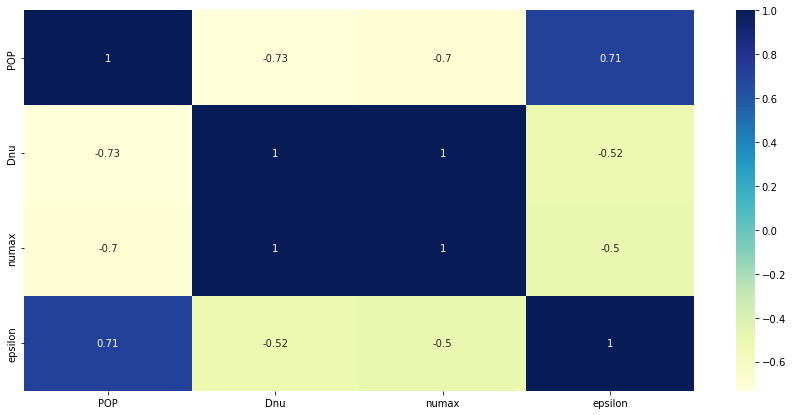

In [8]:
# Validación de correlaciones
correlation = df.corr()
fig1 = plt.figure (figsize = (15,7))
ax = fig1.add_subplot(111)
df.plot = sns.heatmap(correlation, cmap="YlGnBu", annot=True) 
plt.show() 

In [9]:
# Verificamos cuales son las variables que poseen mas correlación con respecto a la variable de salida
df.corr()['POP'].sort_values()

Dnu       -0.733221
numax     -0.703379
epsilon    0.712048
POP        1.000000
Name: POP, dtype: float64

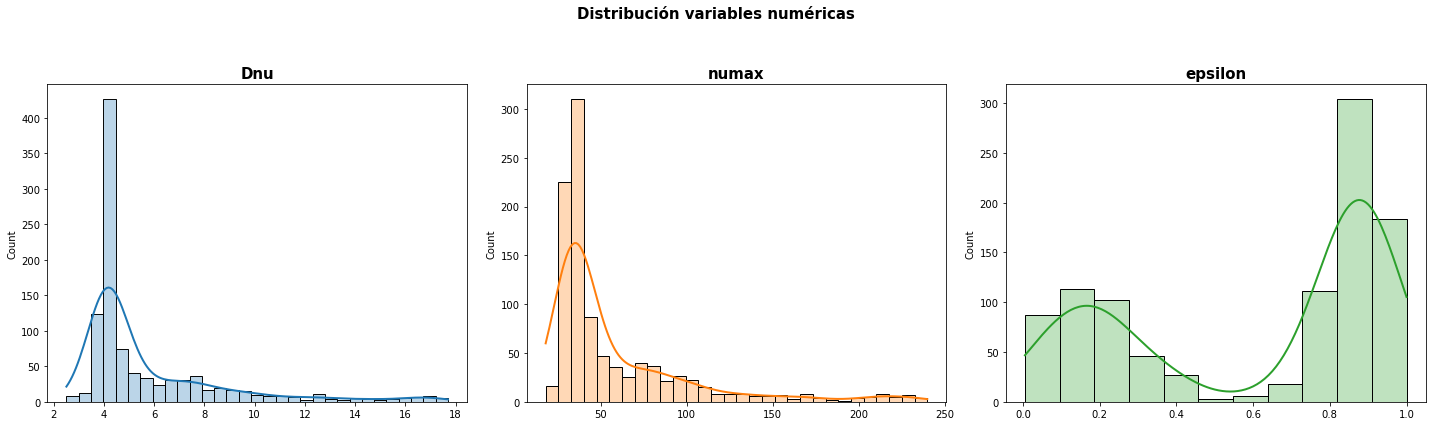

In [10]:
# Gráficas de distribución para cada variable numérica
# Ajustar número de subplots en función del número de columnas
fig2, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
axes = axes.flat
# Seleccionamos el tipo de variable a gráficar
columnas_numeric = df.select_dtypes(include=['float64', 'int']).columns
# Se elimina la variable de salida
columnas_numeric = columnas_numeric.drop('POP')
# Recorremos cada columna seleccionada 
for i, colum in enumerate(columnas_numeric):
    # Gráficamos cada columna 
    sns.histplot(
        data    = df,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 10)
    axes[i].set_xlabel("")

# Se eliminan los axes vacíos
#for i in [5]:
#    fig.delaxes(axes[i])
    
fig2.tight_layout()
plt.subplots_adjust(top = 0.8)
fig2.suptitle('Distribución variables numéricas', fontsize = 15, fontweight = "bold");

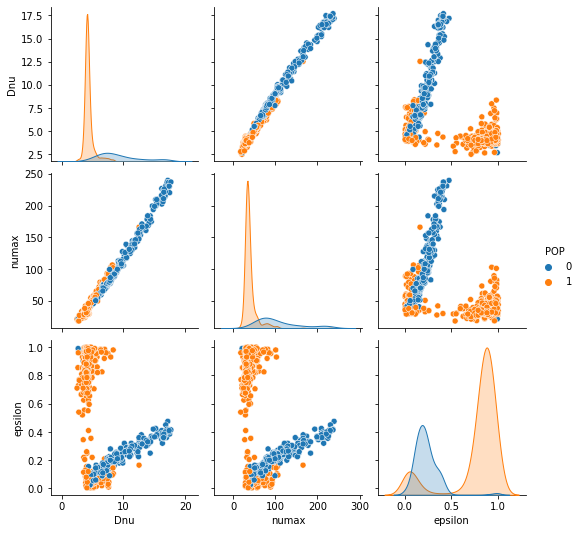

In [11]:
# Correlation matrix for class
sns.pairplot(df, hue="POP")

<Figure size 432x288 with 0 Axes>

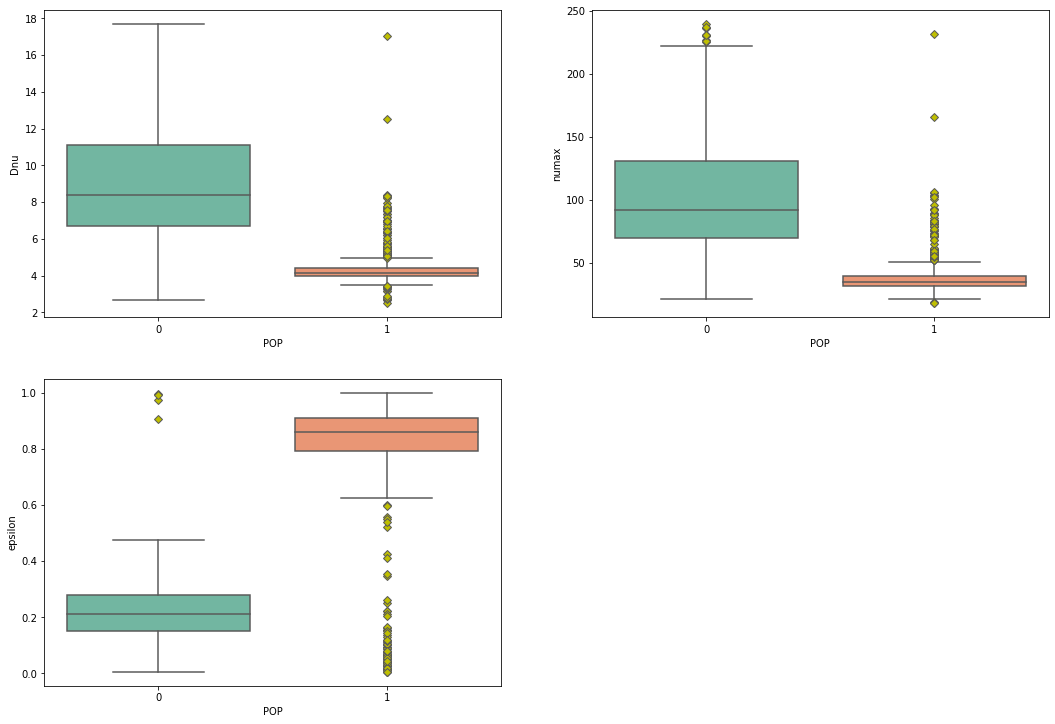

In [12]:
# Boxplot por cada variable
den=pd.DataFrame(df)
plt.figure (4)
plt.subplots(figsize=(18,26))
green_diamond = dict(markerfacecolor='y', marker='D')
sns.set_palette("Set2")

plt.subplot(421)
sns.boxplot(x='POP', y='Dnu', data=den, flierprops=green_diamond)

plt.subplot(422)
sns.boxplot(x='POP', y='numax', data=den, flierprops=green_diamond)

plt.subplot(423)
sns.boxplot(x='POP', y='epsilon', data=den, flierprops=green_diamond)

plt.show() 

## Balanceo del dataset

In [13]:
# Del conjunto de datos general separamos la variable de salida del resto de datos
X_df = df.drop("POP", axis=1)
y_df = df["POP"].copy()

In [14]:
#Validación de la cantidad de ejemplos que posee el dataset segun la variable de salida.
df["POP"].value_counts()

1    713
0    288
Name: POP, dtype: int64

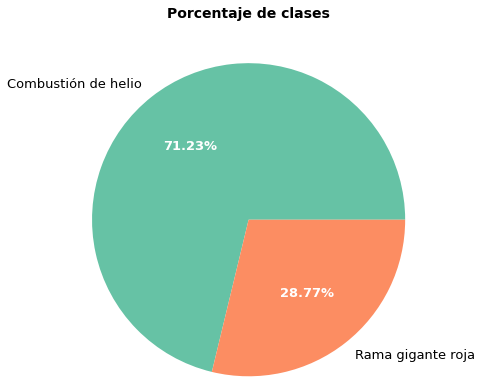

In [15]:
#Creación de una gráfica para representar el porcentaje de las observaciones
Gender = df['POP'].value_counts()
names = 'Combustión de helio','Rama gigante roja'
fig5, ax = plt.subplots(figsize =(8, 6))
_, _, autotexts = ax.pie(x=Gender, labels=names, autopct="%.2f%%", radius=1.2,
                         colors=sns.color_palette("Set2"), explode=None, textprops=dict(fontsize=13))

ax.set_title('Porcentaje de clases', y=1.1,  weight='bold', fontsize=14)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_weight('bold')

El conjunto de datos posee un desbalance con 713 datos de combustión de helio y 288 de ramas gigantes rojas, al entrenar los diferentes algoritmos generaria una matriz de confusión desbalanceda, por lo que se hara uso de la técnica de sobremuestreo para equilibrar la cantidad de datos por clase.

In [16]:
# https://imbalanced-learn.org/dev/over_sampling.html
# Inicializamos el método de sobremuestreo
Ros = RandomOverSampler()#random_state = 0
# Este método duplica las muestras de la clase menos representada
X_Ros, y_Ros = Ros.fit_resample(X_df, y_df)
# Hacemos un nuevo recuento para validar la cantidad de datos por cada caso
No_Ros = y_Ros.sum()
Si_Ros = y_Ros.shape[0]- No_Ros
print('Combustión de helio:', No_Ros ,'Rama gigante roja:', Si_Ros)
# Visualizamos el dataset equilibrado para ambos casos 
X_Ros

Combustión de helio: 713 Rama gigante roja: 713


,Dnu,numax,epsilon
0,4.44780,43.06289,0.985
1,6.94399,74.07646,0.150
2,2.64571,21.57891,0.855
3,4.24168,32.13189,0.840
4,10.44719,120.37356,0.275
...,...,...,...
1421,6.62661,72.94299,0.130
1422,9.79800,109.40116,0.250
1423,17.32071,230.44757,0.405
1424,5.79279,52.85553,0.140


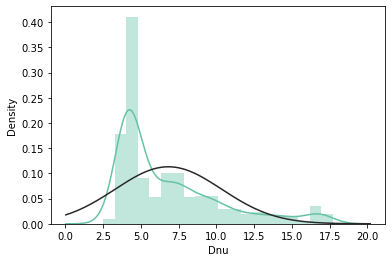

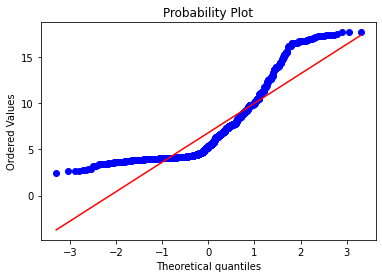

In [17]:
# Histograma y gráfico de probabilidad normal para la variable Dnu:
color=sns.color_palette("Set2")
sns.distplot(X_Ros['Dnu'], fit = norm);
fig8 = plt.figure()
res = stats.probplot(X_Ros['Dnu'], plot = plt)

In [18]:
# Transformación de los datos para la variable Dnu
X_Ros['Dnu'] = np.log(X_Ros['Dnu'])

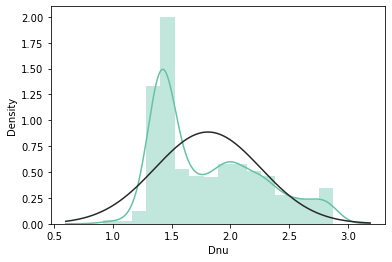

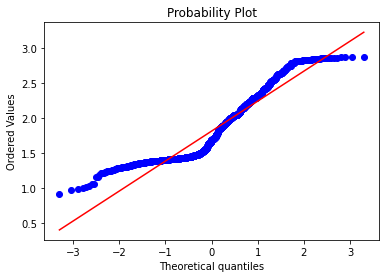

In [19]:
# Histograma y gráfico de probabilidad normal sobre los datos transformados de la variable Dnu:
sns.distplot(X_Ros['Dnu'], fit = norm);
fig9 = plt.figure()
res = stats.probplot(X_Ros['Dnu'], plot = plt)

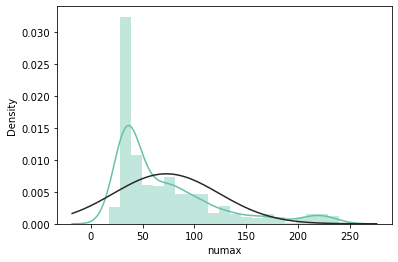

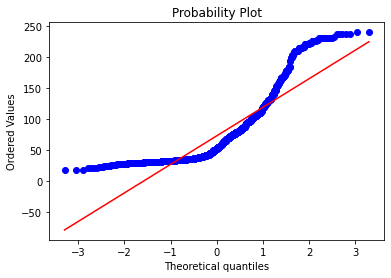

In [20]:
# Histograma y gráfico de probabilidad normal para la variable numax:
sns.distplot(X_Ros['numax'], fit = norm);
fig10 = plt.figure()
res = stats.probplot(X_Ros['numax'], plot = plt)

In [21]:
# Transformación de los datos para la variable numax
X_Ros['numax'] = np.log(X_Ros['numax'])

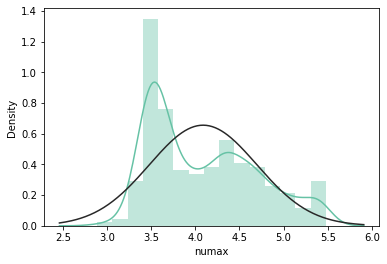

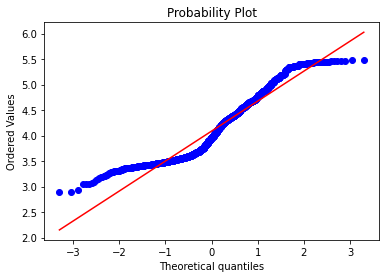

In [22]:
# Histograma y gráfico de probabilidad normal sobre los datos transformados de la variable numax:
sns.distplot(X_Ros['numax'], fit = norm);
fig11 = plt.figure()
res = stats.probplot(X_Ros['numax'], plot = plt)

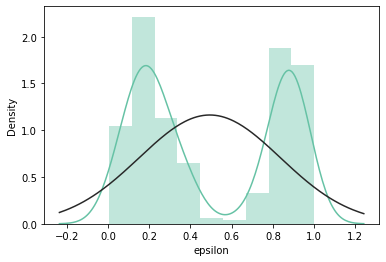

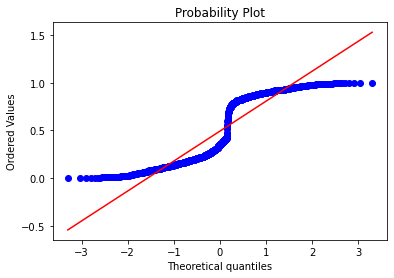

In [23]:
# Histograma y gráfico de probabilidad normal para la variable epsilon:
sns.distplot(X_Ros['epsilon'], fit = norm);
fig12 = plt.figure()
res = stats.probplot(X_Ros['epsilon'], plot = plt)

In [24]:
# Transformación de los datos para la variable epsilon
X_Ros['epsilon'] = np.log(X_Ros['epsilon'])

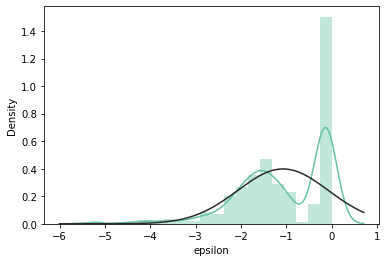

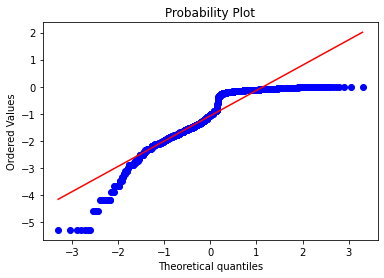

In [25]:
# Histograma y gráfico de probabilidad normal sobre los datos transformados de la variable epsilon:
sns.distplot(X_Ros['epsilon'], fit = norm);
fig13 = plt.figure()
res = stats.probplot(X_Ros['epsilon'], plot = plt)

In [26]:
# Unimos nuevamente la variable de salida al dataset para poder realizar la división de los datos
data_clean= pd.concat([X_Ros,y_Ros], axis=1,sort=True)
# Visualizamos los cambios aplicados
data_clean

,Dnu,numax,epsilon,POP
0,1.492410,3.762662,-0.015114,1
1,1.937877,4.305098,-1.897120,0
2,0.972939,3.071716,-0.156654,1
3,1.444959,3.469849,-0.174353,1
4,2.346333,4.790600,-1.290984,0
...,...,...,...,...
1421,1.891093,4.289678,-2.040221,0
1422,2.282178,4.695021,-1.386294,0
1423,2.851903,5.440023,-0.903868,0
1424,1.756614,3.967562,-1.966113,0


## División del conjunto de datos

In [27]:
# Construcción de una función que realice el particionado completo
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [28]:
# Division del conjunto de datos en los diferentes subconjuntos
train_set, val_set, test_set = train_val_test_split(data_clean, stratify='POP')

In [29]:
# Verificamos las particiones realizadas
print("Longitud del Training Set:", len(train_set))
print("Longitud del Validation Set:", len(val_set))
print("Longitud del Test Set:", len(test_set))

Longitud del Training Set: 855
Longitud del Validation Set: 285
Longitud del Test Set: 286


In [30]:
# Conjunto de datos de entrenamiento
X_train = train_set.drop("POP", axis=1)
y_train = train_set["POP"].copy()

In [31]:
# Conjunto de datos de pruebas
X_val = val_set.drop("POP", axis=1)
y_val = val_set["POP"].copy()

In [32]:
# Conjunto de datos de test
X_test = test_set.drop("POP", axis=1)
y_test = test_set["POP"].copy()

## Selección de los mejores modelos

In [33]:
# Pruebas con diferentes modelos 
models = []
models.append(['Logistic Regreesion', LogisticRegression()])
models.append(['SVM', SVC()])
models.append(['KNeighbors', KNeighborsClassifier()])
models.append(['GaussianNB', GaussianNB()])
models.append(['BernoulliNB', BernoulliNB()])
models.append(['Decision Tree', DecisionTreeClassifier()])
models.append(['Random Forest', RandomForestClassifier()])
models.append(['Ada Boost', AdaBoostClassifier()])

# Entrenamiento de los diferentes modelos
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kFold = KFold(n_splits=10, random_state=7, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kFold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    # Evaluación de los diferentes modelos
    print(f"{name}: {cv_results.mean()*100.0:,.2f}% ({cv_results.std()*100.0:,.2f}%)")

Logistic Regreesion: 92.98% (2.52%)
SVM: 93.45% (3.01%)
KNeighbors: 95.56% (2.48%)
GaussianNB: 92.28% (2.31%)
BernoulliNB: 46.32% (2.45%)
Decision Tree: 96.38% (1.76%)
Random Forest: 97.43% (1.14%)
Ada Boost: 96.02% (1.40%)


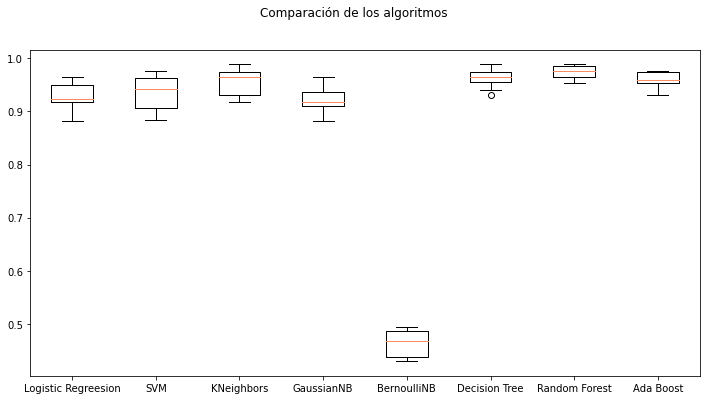

In [34]:
# Gráfica de caja para verificar el rendimiento de los diferentes modelos probados 
fig14 = plt.figure(figsize =(12,6))
fig14.suptitle('Comparación de los algoritmos')
ax = fig14.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Hiperparametrización de los mejores modelos

In [35]:
# Búsqueda de los mejores parámetros para "K-Neighbors"
parameters1 = {"n_neighbors" : [1,3,5],
              "weights": ["uniform", "distance", None],
              "algorithm": ["auto", "ball_tree", "kd_tree", "brute"]
              }

model_KNN = KNeighborsClassifier()
kFold = KFold(n_splits=10, random_state=7, shuffle=True)

grid = GridSearchCV(estimator=model_KNN, param_grid=parameters1, cv=kFold, return_train_score=True)
grid_result1= grid.fit(X_train, y_train)

# mejores parámetros
grid_result1.best_params_

{'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'distance'}

In [36]:
# Búsqueda de los mejores parámetros para "Árboles de decisión"
parameters2 = {"max_depth": [1, 2, 3, None],
              "splitter": ["best", "random"],
              "max_features": [1, 2, 3, "sqrt", "log2"],
              "criterion": ["gini", "entropy", "log_loss"]
              }

model_DTC = DecisionTreeClassifier()
kFold = KFold(n_splits=10, random_state=7, shuffle=True)

grid2 = GridSearchCV(estimator=model_DTC, param_grid=parameters2, cv=kFold, return_train_score=True)
grid_result2= grid2.fit(X_train, y_train)

# mejores parámetros
grid_result2.best_params_

{'criterion': 'log_loss',
 'max_depth': None,
 'max_features': 'sqrt',
 'splitter': 'best'}

In [37]:
# Búsqueda de los mejores parámetros para "Bosques aleatorios"
parameters3 = {"max_depth": [1, 2, 3, None],
              "max_features": [1, 2, 3, "sqrt", "log2"],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy", "log_loss"]
              }

model_RFC = RandomForestClassifier()
kFold = KFold(n_splits=10, random_state=7, shuffle=True)

grid3 = GridSearchCV(estimator=model_RFC, param_grid=parameters3, cv=kFold, return_train_score=True)
grid_result3= grid3.fit(X_train, y_train)

# mejores parámetros
grid_result3.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt'}

## Evaluación del mejor modelo

In [38]:
# Prueba de los mejores modelos con los parámetros encontrados
models_hiper = []
models_hiper.append(['KNeighbors', KNeighborsClassifier(**grid_result1.best_params_)])
models_hiper.append(['Decision Tree', DecisionTreeClassifier(**grid_result2.best_params_)])
models_hiper.append(['Random Forest', RandomForestClassifier(**grid_result3.best_params_)])

# Entrenamiento de los modelos
results2 = []
names2 = []
scoring2 = 'accuracy'
for name, model in models_hiper:
    kFold = KFold(n_splits=10, random_state=7, shuffle=True)
    cv_results2 = cross_val_score(model, X_train, y_train, cv=kFold, scoring=scoring2)
    results2.append(cv_results2)
    names2.append(name)
    # Evaluación de los diferentes modelos
    print(f"{name}: {cv_results2.mean()*100.0:,.2f}% ({cv_results2.std()*100.0:,.2f}%)")

KNeighbors: 97.20% (1.66%)
Decision Tree: 96.50% (2.14%)
Random Forest: 97.43% (1.36%)


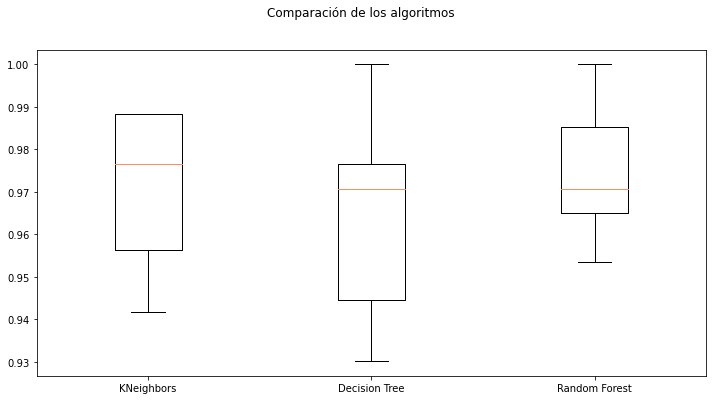

In [39]:
# Gráfica de caja para verificar el rendimiento de los diferentes modelos probados 
fig15 = plt.figure(figsize =(12,6))
fig15.suptitle('Comparación de los algoritmos')
ax = fig15.add_subplot(111)
plt.boxplot(results2)
ax.set_xticklabels(names2)
plt.show()

In [40]:
# Entrenamiento y prueba con el mejor modelo 
# Inicializamos el modelo 
mejor_modelo = RandomForestClassifier(**grid_result3.best_params_)
# Le pasamos los datos de entrenamiento 
mejor_modelo.fit(X_train,y_train)

# Realizamos una nueva predición con los datos de prueba
y_pred = mejor_modelo.predict(X_val)

# Evaluamos el rendimiento del modelo con los datos de prueba 
accuracy_score(y_val, y_pred)

0.9859649122807017

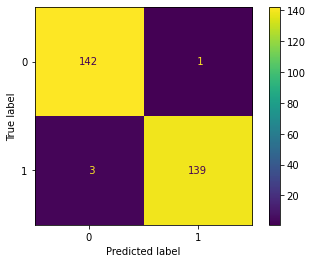

In [41]:
# Resultados de la matriz de confusión con los datos de prueba 
plot_confusion_matrix(mejor_modelo, X_val, y_val, values_format='3g')

In [42]:
# Reporte de los resultados que se obtuvieron con los datos de prueba 
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       143
           1       0.99      0.98      0.99       142

    accuracy                           0.99       285
   macro avg       0.99      0.99      0.99       285
weighted avg       0.99      0.99      0.99       285



In [43]:
# Realizamos una nueva predición con los datos de test
y_pred2 = mejor_modelo.predict(X_test)

# Evaluamos el rendimiento del modelo con los datos de test
accuracy_score(y_test, y_pred2)

0.986013986013986

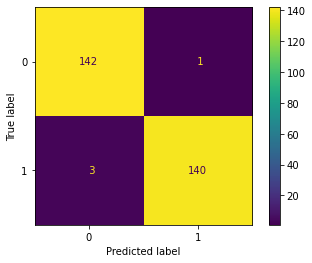

In [44]:
# Resultados de la matriz de confusión con los datos de test
plot_confusion_matrix(mejor_modelo, X_test, y_test, values_format='3g')

In [45]:
# Reporte de los resultados que se obtuvieron con los datos de test
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       143
           1       0.99      0.98      0.99       143

    accuracy                           0.99       286
   macro avg       0.99      0.99      0.99       286
weighted avg       0.99      0.99      0.99       286



## Reducción de características

In [46]:
# Selección de las características más importantes
feature_importances = {name: score for name, score in zip(list(X_train), mejor_modelo.feature_importances_)}
feature_importances_sorted = pd.Series(feature_importances).sort_values(ascending=False)
feature_importances_sorted.head(2)

epsilon    0.351853
Dnu        0.337361
dtype: float64

In [47]:
# Extraemos las 3 características con mas relevancia para el algoritmo
columns = list(feature_importances_sorted.head(2).index)
columns

['epsilon', 'Dnu']

In [48]:
# Aplicamos la reducción de características al dataset de entrenamiento y pruebas
X_train_reduced = X_train[columns].copy()
X_val_reduced = X_val[columns].copy()
X_test_reduced = X_test[columns].copy()
X_train_reduced.head(3)

,epsilon,Dnu
1014,-1.714798,2.040278
771,-0.099820,1.423171
149,-1.290984,2.407513


## Prueba del modelo final 

In [49]:
# Prueba de los mejores modelos con el dataset reducido
models_hiper2 = []
models_hiper2.append(['KNeighbors', KNeighborsClassifier(**grid_result1.best_params_)])
models_hiper2.append(['Decision Tree', DecisionTreeClassifier(**grid_result2.best_params_)])
models_hiper2.append(['Random Forest', RandomForestClassifier(**grid_result3.best_params_)])

# Entrenamiento de los modelos
results3 = []
names3 = []
scoring3 = 'accuracy'
for name, model in models_hiper2:
    kFold = KFold(n_splits=10, random_state=7, shuffle=True)
    cv_results3 = cross_val_score(model, X_train_reduced, y_train, cv=kFold, scoring=scoring3)
    results3.append(cv_results3)
    names3.append(name)
    # Evaluación de los diferentes modelos
    print(f"{name}: {cv_results3.mean()*100.0:,.2f}% ({cv_results3.std()*100.0:,.2f}%)")

KNeighbors: 96.61% (1.97%)
Decision Tree: 96.85% (1.57%)
Random Forest: 97.43% (1.71%)


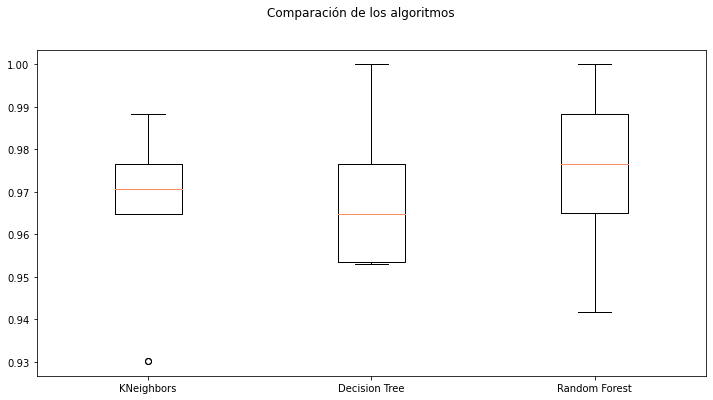

In [50]:
# Gráfica de caja para verificar el rendimiento de los diferentes modelos entrenados con el dataset reducido
fig16 = plt.figure(figsize =(12,6))
fig16.suptitle('Comparación de los algoritmos')
ax = fig16.add_subplot(111)
plt.boxplot(results3)
ax.set_xticklabels(names3)
plt.show()

In [51]:
# Probamos el modelo nuevamente con el dataset reducido 
# Inicializamos el modelo 
mejor_modelo2 = RandomForestClassifier(**grid_result3.best_params_)
# Le pasamos los datos de entrenamiento 
mejor_modelo2.fit(X_train_reduced,y_train)

# Realizamos una nueva predición con los datos de prueba
y_pred3 = mejor_modelo2.predict(X_val_reduced)

# Evaluamos el rendimiento del modelo con los datos de prueba 
accuracy_score(y_val, y_pred3)

0.9894736842105263

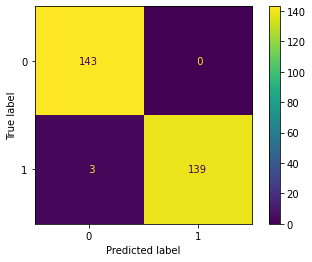

In [52]:
# Resultados de la matriz de confusión con los datos de prueba 
plot_confusion_matrix(mejor_modelo2, X_val_reduced, y_val, values_format='3g')

In [53]:
# Reporte de los resultados que se obtuvieron con los datos de prueba 
print(classification_report(y_val, y_pred3))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       143
           1       1.00      0.98      0.99       142

    accuracy                           0.99       285
   macro avg       0.99      0.99      0.99       285
weighted avg       0.99      0.99      0.99       285



In [54]:
# Realizamos una nueva predición con los datos de test
y_pred4 = mejor_modelo2.predict(X_test_reduced)

# Evaluamos el rendimiento del modelo con los datos de test
accuracy_score(y_test, y_pred4)

0.9895104895104895

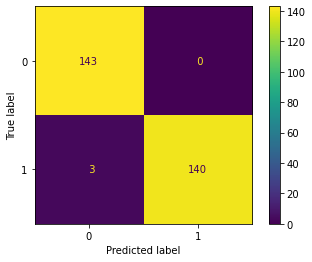

In [55]:
# Resultados de la matriz de confusión con los datos de test
plot_confusion_matrix(mejor_modelo2, X_test_reduced, y_test, values_format='3g')

In [56]:
# Reporte de los resultados que se obtuvieron con los datos de test
print(classification_report(y_test, y_pred4))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       143
           1       1.00      0.98      0.99       143

    accuracy                           0.99       286
   macro avg       0.99      0.99      0.99       286
weighted avg       0.99      0.99      0.99       286

